In [6]:
import pandas as pd
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

2022-10-30 15:04:21.023470: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [8]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess= tf.compat.v1.Session(config=config)

2022-10-30 15:04:22.372281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 15:04:23.057663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46286 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-10-30 15:04:23.058232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46166 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6


In [9]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("cfilt/iitb-english-hindi")

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/home/karan/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
})

In [7]:
source_train_file = open("source_train.txt", "w+", encoding='utf8')
target_train_file = open("target_train.txt", "w+", encoding='utf8')
for translation_pair in dataset["train"]["translation"]:
    source_sentence = translation_pair["en"]
    target_sentence = translation_pair["hi"]
    source_train_file.write(source_sentence.strip("\n") + "\n")
    target_train_file.write(target_sentence.strip("\n") + "\n")
source_train_file.close()
target_train_file.close()

source_valid_file = open("source_valid.txt", "w+", encoding='utf8')
target_valid_file = open("target_valid.txt", "w+", encoding='utf8')
for translation_pair in dataset["validation"]["translation"]:
    source_sentence = translation_pair["en"]
    target_sentence = translation_pair["hi"]
    source_valid_file.write(source_sentence.strip("\n") + "\n")
    target_valid_file.write(target_sentence.strip("\n") + "\n")
source_valid_file.close()
target_valid_file.close()

source_test_file = open("source_test.txt", "w+", encoding='utf8')
target_test_file = open("target_test.txt", "w+", encoding='utf8')
for translation_pair in dataset["test"]["translation"]:
    source_sentence = translation_pair["en"]
    target_sentence = translation_pair["hi"]
    source_test_file.write(source_sentence.strip("\n") + "\n")
    target_test_file.write(target_sentence.strip("\n") + "\n")
source_test_file.close()
target_test_file.close()

In [10]:
eng_train = [line.rstrip() for line in open('source_train.txt')]
hi_train = [line.rstrip() for line in open('target_train.txt')]

In [11]:
print(len(eng_train),len(hi_train))

1659083 1659083


In [21]:
eng_train = eng_train[:100000]
hi_train =hi_train[:100000]

In [22]:
eng_train[:5]

['Give your application an accessibility workout',
 'Accerciser Accessibility Explorer',
 'The default plugin layout for the bottom panel',
 'The default plugin layout for the top panel',
 'A list of plugins that are disabled by default']

In [23]:
hi_train[:5]

['अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें',
 'एक्सेर्साइसर पहुंचनीयता अन्वेषक',
 'निचले पटल के लिए डिफोल्ट प्लग-इन खाका',
 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका',
 'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है']

In [24]:
text_pairs = []
for eng, hi in zip(eng_train, hi_train):
    hi = "[start] " + hi + " [end]"
    text_pairs.append((eng, hi))

In [25]:
for _ in range(5):
    print(random.choice(text_pairs))

('Search in project files', '[start] खोलें फ़ाइल [end]')
('Add wire outlines for all geometry', '[start] सारे ज्यामिति के लिए तार रूपरेखा जोड़ें [end]')
('Changes the visibility of the image gallery pane in the current window', '[start] परिवर्तन का छवि इंच विंडो [end]')
('Allows files not stored locally to be burned', '[start] उन फाइलों जो स्थानीय रूप से जमा नहीं है को लिखने देता है [end]')
('Widgets', '[start] विजेट्स [end]')


In [26]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

100000 total pairs
70000 training pairs
15000 validation pairs
15000 test pairs


In [27]:
all_lengths=[]
for en,hi in zip(eng_train,hi_train):
    all_lengths.append(max(len(en.split()),len(hi.split())))

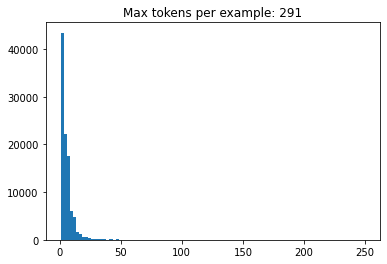

In [28]:
plt.hist(all_lengths, np.linspace(np.min(all_lengths), 250, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
# plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');

In [29]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# vocab_size = 15000
sequence_length = 50
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(output_mode="int", output_sequence_length=sequence_length,)

hi_vectorization = TextVectorization(
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_hi_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
hi_vectorization.adapt(train_hi_texts)

In [30]:
def format_dataset(eng, hi):
    eng = eng_vectorization(eng)
    hi = hi_vectorization(hi)
    return ({"encoder_inputs": eng, "decoder_inputs": hi[:, :-1],}, hi[:, 1:])


def make_dataset(pairs):
    eng_texts, hi_texts = zip(*pairs)
    hi_texts = list(hi_texts)
    eng_texts = list(eng_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, hi_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [31]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 50)
inputs["decoder_inputs"].shape: (64, 50)
targets.shape: (64, 50)


2022-10-30 15:17:41.977687: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


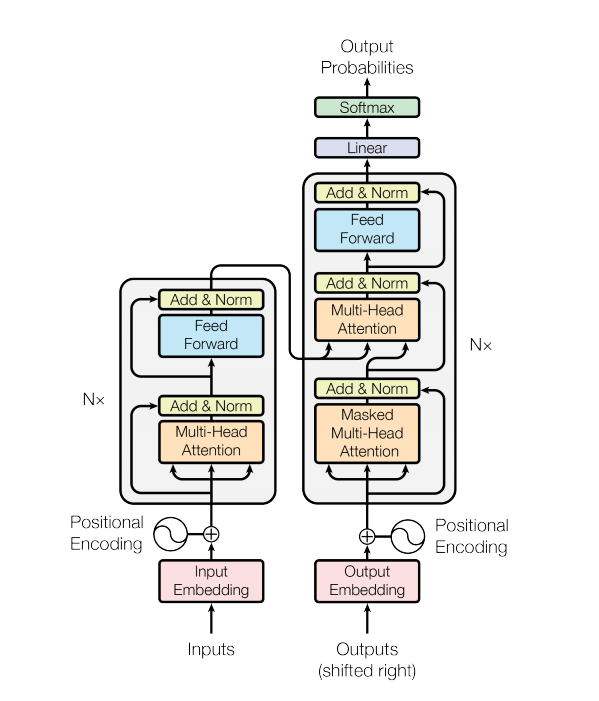

In [32]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True 

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


In [33]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)

x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

x = layers.Dropout(0.5)(x)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3852800     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [114]:
embed_dim = 128
latent_dim = 512
num_heads = 8
no_blocks = 4

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
x = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)

for i in range(no_blocks):
    x = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)

encoder_outputs = x

# x = Encoder_layer(no_blocks, embed_dim, latent_dim, num_heads)(x)
# encoder_outputs=x
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)

for _ in range(no_blocks):
    x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)


# x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
# x = layers.Dropout(0.5)(x)    
    
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 128)   1929600     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 128)   659712      ['positional_embedding_2[0][0]'] 
 rmerEncoder)                                                                                     
                                                                                        

In [34]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name='RMSprop',
)

checkpoint_path = './checkpoints/Eng_to_Spa_train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [35]:
epochs = 100  # This should be at least 30 for convergence

checkpoint = ModelCheckpoint('Eng_to_Hindi' + ".hdf5", monitor='loss',
    save_best_only=True, mode='auto',save_freq="epoch",)

transformer.compile(
    optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/100


2022-10-30 15:18:21.842760: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-30 15:18:22.195880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


1094/1094 [==============================] - 51s 42ms/step - loss: 0.5775 - accuracy: 0.4190 - val_loss: 0.4256 - val_accuracy: 0.5461
Epoch 2/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.3941 - accuracy: 0.5886 - val_loss: 0.3301 - val_accuracy: 0.6498
Epoch 3/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.3179 - accuracy: 0.6662 - val_loss: 0.2950 - val_accuracy: 0.6955
Epoch 4/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.2844 - accuracy: 0.7088 - val_loss: 0.2739 - val_accuracy: 0.7262
Epoch 5/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.2629 - accuracy: 0.7371 - val_loss: 0.2576 - val_accuracy: 0.7453
Epoch 6/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.2473 - accuracy: 0.7570 - val_loss: 0.2482 - val_accuracy: 0.7599
Epoch 7/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.2358 - accuracy: 0.7719 - val_loss: 0.2392 - val_

1094/1094 [==============================] - 46s 42ms/step - loss: 0.1375 - accuracy: 0.8776 - val_loss: 0.1653 - val_accuracy: 0.8622
Epoch 57/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.1369 - accuracy: 0.8777 - val_loss: 0.1647 - val_accuracy: 0.8613
Epoch 58/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.1363 - accuracy: 0.8783 - val_loss: 0.1659 - val_accuracy: 0.8621
Epoch 59/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.1361 - accuracy: 0.8790 - val_loss: 0.1672 - val_accuracy: 0.8584
Epoch 60/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.1358 - accuracy: 0.8792 - val_loss: 0.1637 - val_accuracy: 0.8647
Epoch 61/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.1354 - accuracy: 0.8793 - val_loss: 0.1639 - val_accuracy: 0.8639
Epoch 62/100
1094/1094 [==============================] - 46s 42ms/step - loss: 0.1347 - accuracy: 0.8799 - val_loss: 0.1636 

In [41]:
hi_vocab = hi_vectorization.get_vocabulary()
hi_index_lookup = dict(zip(range(len(hi_vocab)), hi_vocab))
max_decoded_sentence_length = sequence_length


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = hi_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = hi_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    
    print(input_sentence, translated)

(One of the Standard 14 Fonts) [start] मानक गुम हो गया है डिस्क [end]
Sensitive [start] संवेदनशील [end]
You have already given proxy permissions to this user. [start] आपके पास पहले से प्राक्सी अनुमति दी प्रयोग नहीं है [end]
MD5 Fingerprint: [start] md5 फिंगरप्रिंट [end]
_ Select [start] चुनें [end]
_ Rooms [start] कक्ष r [end]
“% s” is not a valid contact ID [start] अवैध संपर्क [end]
Invalid query [start] अवैध प्रश्न [end]
% s asks the permission to see your presence. [start] s आपकी उपस्थिति को देखने के लिए अनुमति चाहता है [end]
% s Invite required:% s Password required:% s Members:% s [start] s आमंत्रण [end]
Create a video DVD or an SVCD that are readable on TV readers [start] एक विडियो डीवीडी या एसवीसीडी बनाएँ जो कि टीवी फ़ाइल में तैयार है [end]
Highlight All [start] सभी आलोकित करें [end]
A _ ttach [start] एक [end]
Select the game type to play [start] [end]
Subversion: Copy complete. [start] सबवर्सन नक़ल पूर्ण [end]
Line _ Wrapping [start] पंक्ति [end]
Whether to use the "- immed" fl